In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import warnings
warnings.filterwarnings("ignore")
import pickle
import sys
main_path = r'../..'
sys.path.append(main_path)
from BayDS import *

Using TensorFlow backend.


In [2]:
main_folder = r'../../Snapshots/Stacking/data'
model_folder = r'../../Snapshots/Stacking/12.09'

In [3]:
train = pd.read_pickle(f'../../Data/train_09457_with_additions.pkl')
test = pd.read_pickle(f'../../Data/test_09457_with_additions.pkl')


In [4]:
L = os.listdir(main_folder)
oof = pd.DataFrame(index=train.index)
prediction = pd.DataFrame(index=test.index)
for experiment_name in L:
    experiment_folder = os.path.join(main_folder,experiment_name)
    if not os.path.exists(f'{experiment_folder}/results_dict.pkl'):
        continue
    results_dict = pd.read_pickle(f'{experiment_folder}/results_dict.pkl')
    print(experiment_name, sum(results_dict['scores'])/len(results_dict['scores']))
    oof[experiment_name] = results_dict['oof'][:,0]
    prediction[experiment_name] = results_dict['prediction'][:,0]
y = train.isFraud
    

keras-1 0.9369870255428566
keras-4 0.9384344028402574
keras-4Layer 0.9318094575694726


In [6]:
# add best lgbm model
oof_lgbm = pd.read_csv(main_folder+'/Best09457/oof_best_submit.csv')
sub = pd.read_csv(main_folder+'/Best09457/ieee_with_additions.csv')
oof_lgbm.set_index('TransactionID', inplace=True)
sub.set_index('TransactionID', inplace=True)
assert(np.all(oof_lgbm.index == oof.index))
assert(np.all(sub.index == prediction.index))

In [7]:
oof['BestLGBM'] = oof_lgbm['score']
prediction['BestLGBM'] = sub['isFraud']


In [8]:
del train
del test

In [9]:
n_fold = 5
folds = KFold(n_splits=n_fold)

In [10]:
prediction.shape

(506691, 4)

In [11]:
for col in oof.columns:
    print(col,fast_auc(y,oof[col]))

keras-1 0.9333670008488467
keras-4 0.935259000160181
keras-4Layer 0.9282044589502246
BestLGBM 0.9369916830129429


## Blending

In [42]:
def blend_auc(alpha):
    blend = oof['keras-4']*(1-alpha)+oof['BestLGBM']*alpha
    return fast_auc(y,blend)
blend_auc(1)

0.9369916830129429

In [43]:
L = np.linspace(0,1,50)
scores = [blend_auc(l) for l in L]

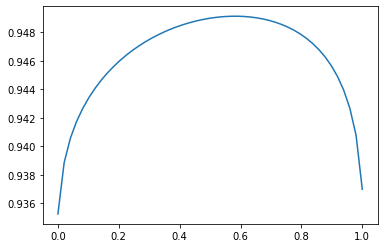

In [44]:
plt.plot(L,scores)

In [31]:
from scipy.optimize import minimize

In [38]:
alpha_min = minimize(blend_auc,0.5,method='L-BFGS-B',options={'disp':1})

In [39]:
alpha_min

      fun: -0.9491430602369693
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 2
   status: 0
  success: True
        x: array([0.58379335])

In [21]:
blend.index

Int64Index([3663549, 3663550, 3663551, 3663552, 3663553, 3663554, 3663555,
            3663556, 3663557, 3663558,
            ...
            4170230, 4170231, 4170232, 4170233, 4170234, 4170235, 4170236,
            4170237, 4170238, 4170239],
           dtype='int64', name='TransactionID', length=506691)

In [22]:
sub.index

RangeIndex(start=0, stop=506691, step=1)

In [25]:
sub = pd.read_csv(f'../../data/sample_submission.csv')
sub.set_index('TransactionID',inplace=True)
sub['isFraud'] = blend['blend']
sub.to_csv(f'{model_folder}/blender.csv')

In [22]:
import pickle
with open(f'{model_folder}/results_dict.pkl', 'wb') as f:
#     q = json.dumps(result_dict_lgb,indent=2)
    pickle.dump(result_dict_keras,f)
#     f.write(q)